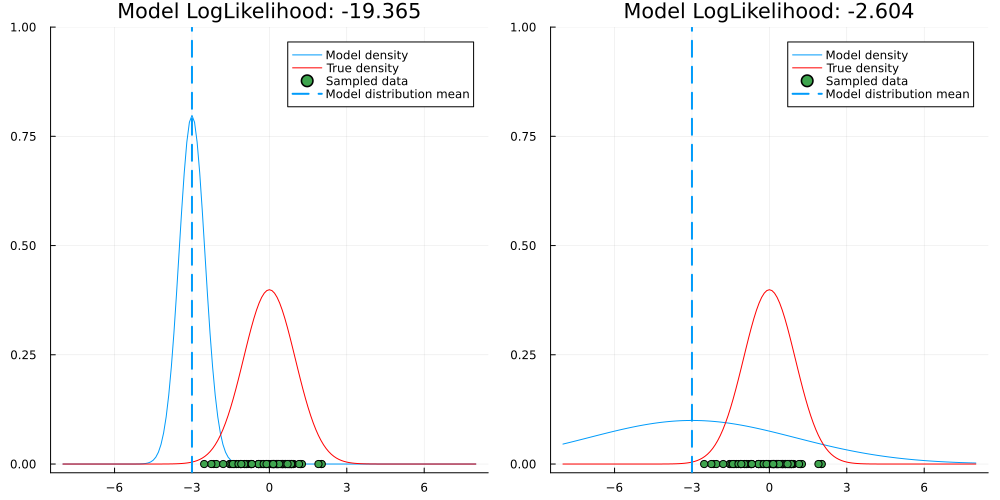

In [299]:
using Distributions, Random, Printf
Random.seed!(123)

data = randn(100)

dist1 = Normal(-3,0.5)
dist2 = Normal(-3,4)

ll1 = mean(logpdf.(dist1,data))
ll2 = mean(logpdf.(dist2,data))

line = collect(-8:0.1:8)

p1 = plot(line, pdf.(dist1,line), label="Model density", size=(1000,500), 
          ylim=(-0.02,1), title=@sprintf "Model LogLikelihood: %.3f" ll1)
plot!(p1, line,pdf.(Normal(),line),color=:red, label="True density")
scatter!(p1, data, zeros(100), label="Sampled data")
vline!(p1, [-3], color=1, linestyle=:dash, lw=2, label = "Model distribution mean")

p2 = plot(line, pdf.(dist2,line), label="Model density", size=(1000,500), 
          ylim=(-0.02,1), title=@sprintf "Model LogLikelihood: %.3f" ll2)
plot!(p2, line,pdf.(Normal(),line),color=:red, label="True density")
scatter!(p2, data, zeros(100), label="Sampled data")
vline!(p2, [-3], color=1, linestyle=:dash, lw=2, label = "Model distribution mean")

plot(p1,p2, size=(1000,500), fmt=:png)

In [281]:
ll1

-19.364897862569727

In [278]:
ll2

-2.6042814335421416

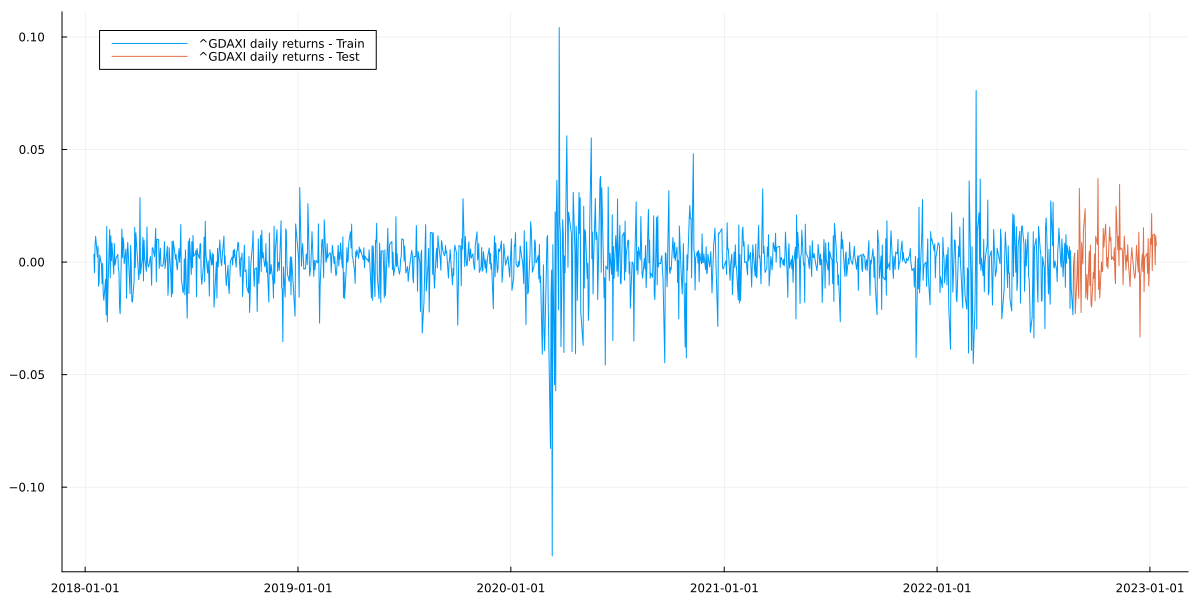

In [1]:
using Plots, CSV, DataFrames

#https://de.finance.yahoo.com/quote/%5EGDAXI/history?period1=1515801600&period2=1673568000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = CSV.File("GDAXI.csv") |> DataFrame

a_close_raw = df[!,["Adj Close", "Date"]]
a_close_nonull = a_close_raw[findall(a_close_raw[!,"Adj Close"].!= "null"),:]
a_close = parse.(Float32, a_close_nonull[!,"Adj Close"])

returns = diff(log.(a_close))

train = returns[1:end-99]
train_idx = a_close_nonull[!,"Date"][2:end-99]

test = returns[end-99:end]
test_idx = a_close_nonull[!,"Date"][end-99:end]

plot(train_idx,train, label="^GDAXI daily returns - Train", size = (1200,600), fmt=:png)
plot!(test_idx, test, label="^GDAXI daily returns - Test")

In [2]:
using Flux, Distributions


struct VarCoeffGARCH
    constant::Vector{Float32}
    net::Chain
    
    x0::Vector{Float32}
end
Flux.@functor VarCoeffGARCH

VarCoeffGARCH(net::Chain) = VarCoeffGARCH([-9], net, [0.0])


function garch_mean_ll(m::VarCoeffGARCH, y::Vector{Float32})::Float32
    sigmas, _ = garch_forward(m,y)
    conditional_dists = Normal.(0, sigmas)
    
    return mean(logpdf.(conditional_dists, y))
end


#Use functional implementation to calculate conditional stddev.
#Then, we don't need to store stddev_t to calculate stddev_t+1
#and thus avoid mutation, which doesn't work with Zygote
#(could use Zygote.Buffer, but it's often discouraged)
function garch_forward(m::VarCoeffGARCH, y::Vector{Float32})
    
    sigma_1, params_1 = m(m.x0[1], sqrt(softplus(m.constant[1])))
    
    sigma_rec, params_rec = garch_forward_recurse(m, sigma_1, y, 1)
    
    sigmas_result = vcat(sigma_1, sigma_rec)
    params_result = hcat(params_1, params_rec)
    
    return sigmas_result, params_result
    
end

function garch_forward_recurse(m::VarCoeffGARCH, sigma_tm1::Float32, y::Vector{Float32}, t::Int64)
    
    sigma_t, params_t = m(y[t], sigma_tm1)
    
    if t==length(y)-1
        return sigma_t, params_t
    end
    
    sigma_rec, params_rec = garch_forward_recurse(m, sigma_t, y, t+1)
    
    sigmas_result = vcat(sigma_t, sigma_rec)
    params_result = hcat(params_t, params_rec)
    
    return sigmas_result, params_result
end


function (m::VarCoeffGARCH)(y::Float32, sigma::Float32)
    
    input_vec = vcat(y, sigma)
    
    params = m.net(input_vec)
    params_stable = get_garch_stable_params(params) #to ensure stationarity of the resulting GARCH process
        
    return sqrt(softplus(m.constant[1]) + sum(input_vec.^2 .* params_stable)), params_stable
end

#transform both parameters to be >0 each and their sum to be <1
get_garch_stable_params(x::Vector{Float32}) = vcat(σ(x[1]), (1-σ(x[1]))*σ(x[2]))

get_garch_stable_params (generic function with 1 method)

In [237]:
using Random, Zygote

Random.seed!(123)

model = VarCoeffGARCH(Chain(Dense(2,2,softplus), Dense(2,2,softplus), Dense(2,2)))
params = Flux.params(model)

opt = ADAM(0.05)

for i in 1:500
    grads = Zygote.gradient(()->-garch_mean_ll(model, train), params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i%50==0
        println(garch_mean_ll(model,train))
    end
end

3.038939
3.0580537
3.0621195
3.0658002
3.069259
3.0699775
3.0751026
3.0757551
3.0642645
3.080713


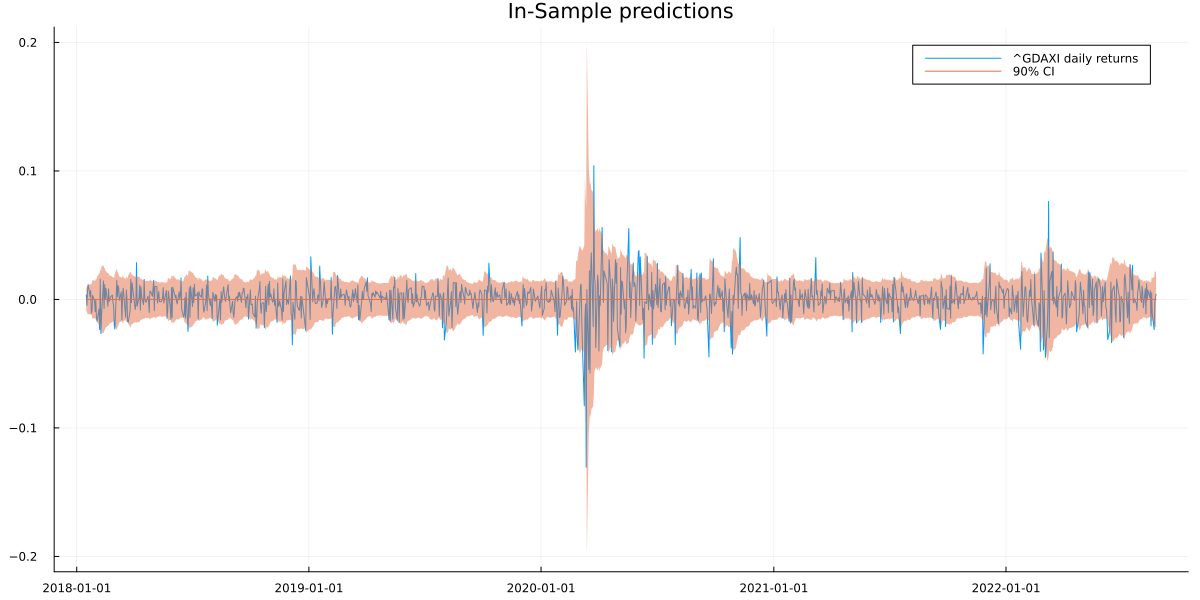

In [238]:
sigmas, params = garch_forward(model,train)

lower = quantile.(Normal.(0,sigmas),0.05)
upper = quantile.(Normal.(0,sigmas),0.95)

plot(train_idx, train, label="^GDAXI daily returns", size = (1200,600), title="In-Sample predictions", fmt=:png)
plot!(train_idx, zeros(length(lower)), ribbon=(upper,-lower),label = "90% CI")

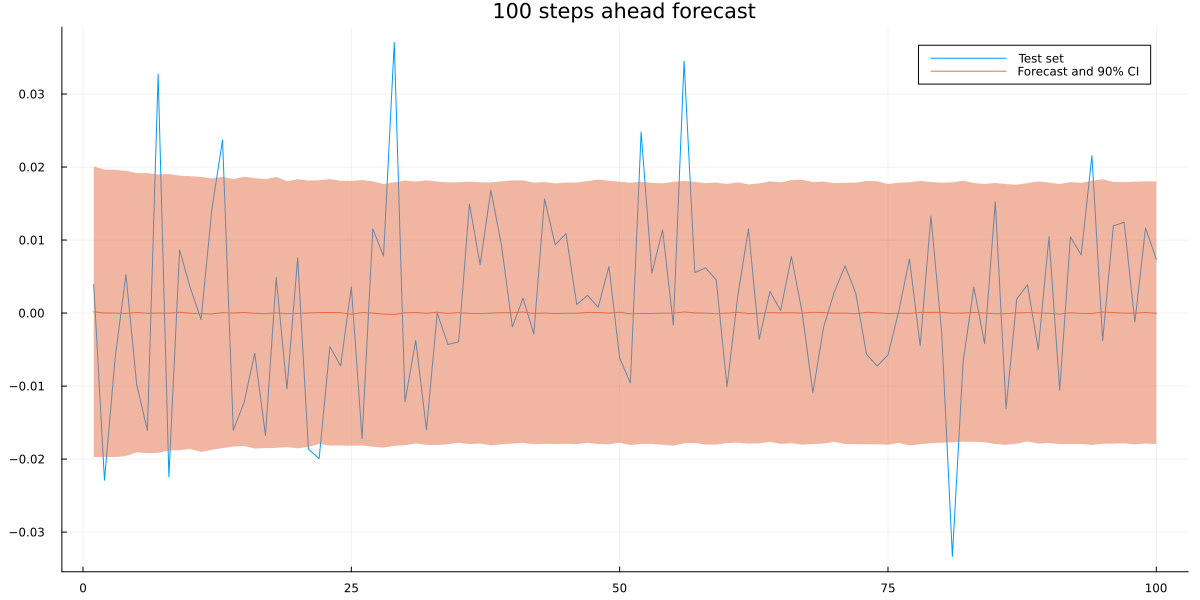

In [239]:
function garch_forward_sample(m::VarCoeffGARCH, sigma_tm1::Float32, y_tm1::Float32, t::Int64, T::Int64=100)
    
    sigma_t, params_t = m(y_tm1, sigma_tm1)
    sample_t = randn(Float32)*sigma_t
    
    if t==T
        return sigma_t, sample_t, params_t
    end
    
    sigma_rec, sample_rec, params_rec = garch_forward_sample(m, sigma_t, sample_t, t+1, T)
    
    sigmas_result = vcat(sigma_t, sigma_rec)
    sample_result = vcat(sample_t, sample_rec)
    params_result = vcat(params_t, params_rec)
    
    return sigmas_result, sample_result, params_result
    
end

Random.seed!(123)

mc_simulation = [garch_forward_sample(model, sigmas[end], train[end], 1) for _ in 1:25000]

sigma_sample = hcat(map(x->x[1], mc_simulation)...)
y_forecast_sample = hcat(map(x->x[2], mc_simulation)...)
params1_sample = hcat(map(x->x[3], mc_simulation)...)
params2_sample = hcat(map(x->x[3], mc_simulation)...)

y_forecast_mean = mean(y_forecast_sample,dims=2)[:]
y_forecast_lower = mapslices(x->quantile(x,0.05), y_forecast_sample, dims=2)[:]
y_forecast_upper = mapslices(x->quantile(x,0.95), y_forecast_sample, dims=2)[:]

plot(test[1:100], size = (1200,600), title = "100 steps ahead forecast", label="Test set", fmt=:png)
plot!(y_forecast_mean, ribbon = (y_forecast_upper.-y_forecast_mean, y_forecast_mean.-y_forecast_lower), label="Forecast and 90% CI")

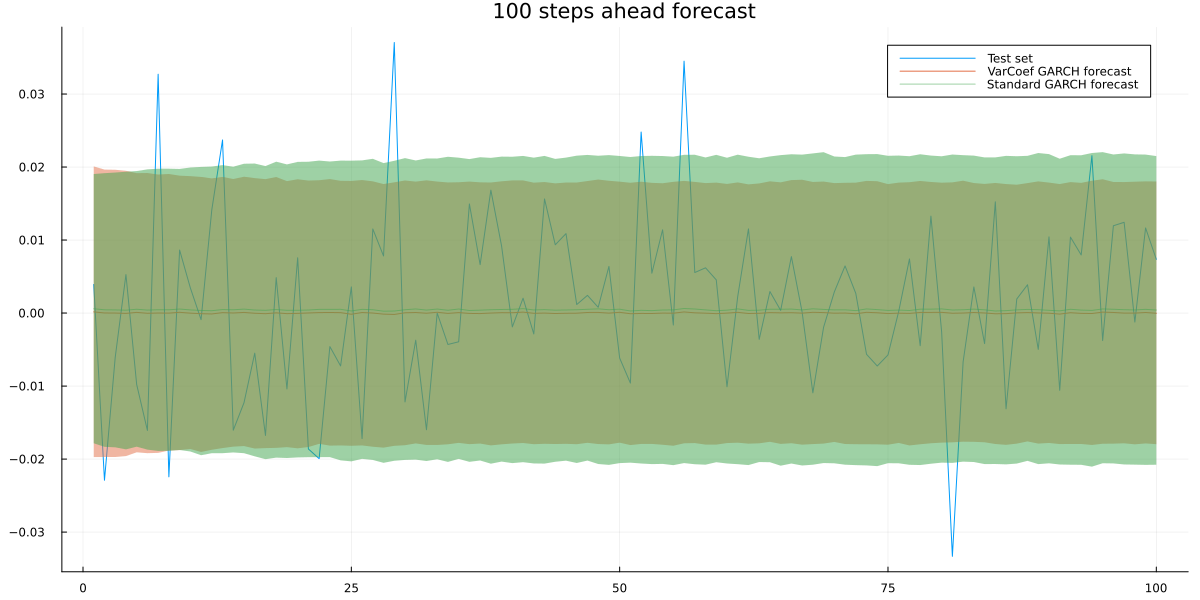

In [241]:
using ARCHModels

garch_model = fit(GARCH{1,1}, train)
garch_model_dummy = fit(GARCH{1,1}, train[1:end-1]) #to get latent variance of final training observation


Random.seed!(123)

var_T = predict(garch_model_dummy, :variance, 1)
y_T = train[end]

garch_coefs = garch_model.spec.coefs
mean_coef = garch_model.meanspec.coefs[1]

garch_sigma_sample = zeros(100,25000)
garch_forecast_sample = zeros(100,25000)

for i in 1:25000
    sigma_1 = sqrt(garch_coefs[1] + garch_coefs[2]*var_T + garch_coefs[3]*(y_T-mean_coef)^2)
    garch_sigma_sample[1,i] = sigma_1
    
    forecast_sample = randn()*sigma_1+mean_coef
    garch_forecast_sample[1,i] = forecast_sample
    
    for t in 2:100
        var_tm1 = garch_sigma_sample[t-1,i]^2
        eps_tm1 = (garch_forecast_sample[t-1,i]-mean_coef)^2
        
        sigma_t = sqrt(garch_coefs[1] + garch_coefs[2]*var_tm1 + garch_coefs[3]*eps_tm1)
        garch_sigma_sample[t,i] = sigma_t
        
        forecast_sample = randn()*sigma_t+mean_coef
        garch_forecast_sample[t,i] = forecast_sample
    end
end
    
garch_forecast_mean = mean(garch_forecast_sample,dims=2)[:]
garch_forecast_lower = mapslices(x->quantile(x,0.05), garch_forecast_sample, dims=2)[:]
garch_forecast_upper = mapslices(x->quantile(x,0.95), garch_forecast_sample, dims=2)[:]

plot(test[1:100], size = (1200,600), title = "100 steps ahead forecast", label="Test set", fmt=:png)
plot!(y_forecast_mean, ribbon = (y_forecast_upper.-y_forecast_mean, y_forecast_mean.-y_forecast_lower), label="VarCoef GARCH forecast")
plot!(garch_forecast_mean, 
      ribbon = (garch_forecast_upper.-garch_forecast_mean, garch_forecast_mean.-garch_forecast_lower),
      label="Standard GARCH forecast", alpha=0.5)

In [245]:
using KernelDensity
var_coef_ll = mean([log(pdf(kde(y_forecast_sample[t,:]),test[t])) for t in 1:100])
standard_ll = mean([log(pdf(kde(garch_forecast_sample[t,:]),test[t])) for t in 1:100])

println(var_coef_ll)
println(standard_ll)

3.012266797283187
3.0003596946242705


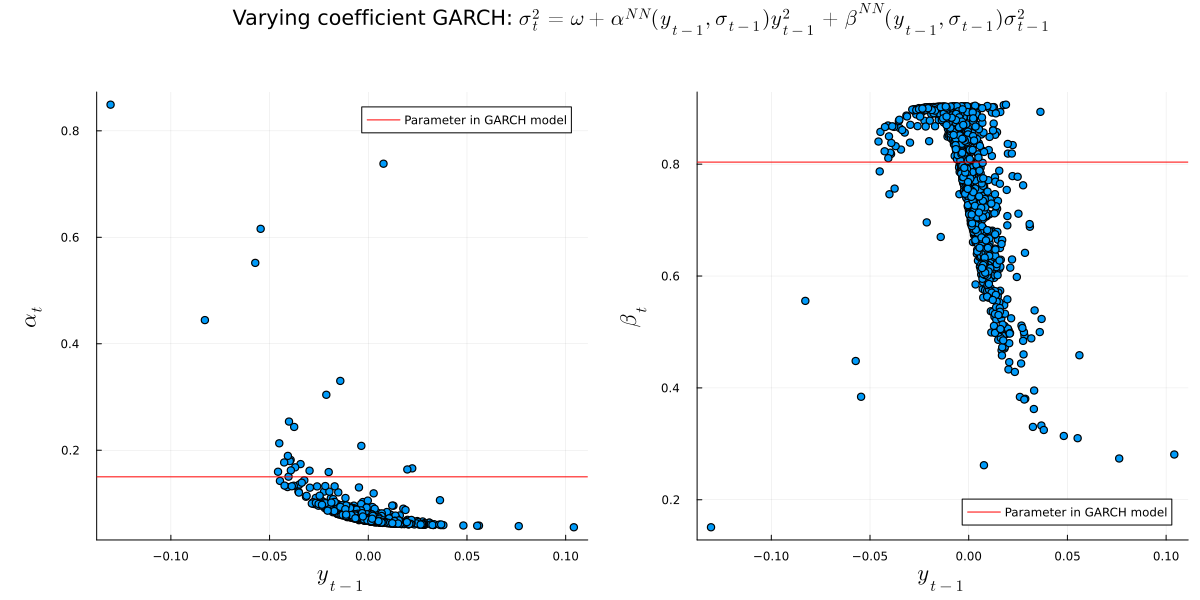

In [254]:
using LaTeXStrings

title = plot(title = "Varying coefficient GARCH: "*L"\sigma^2_t=\omega + \alpha^{NN}(y_{t-1},\sigma_{t-1})y^2_{t-1}+\beta^{NN}(y_{t-1},\sigma_{t-1})σ^2_{t-1}", grid = false, showaxis = false)


p1 = scatter(train[1:end-1], params[1,2:end], label=:none, guidefontsize=15)
xlabel!(p1,L"y_{t-1}")
ylabel!(p1,L"\alpha_t")
hline!([garch_coefs[3]], color=:red, label="Parameter in GARCH model")


p2 = scatter(train[1:end-1], params[2,2:end], label=:none, guidefontsize=15)
xlabel!(p2,L"y_{t-1}")
ylabel!(p2,L"\beta_t")
hline!([garch_coefs[2]], color=:red, label="Parameter in GARCH model")


plot(title, p1, p2, layout = @layout([A{0.01h}; [B C]]), size = (1200,600), left_margin=10*Plots.mm, bottom_margin=5*Plots.mm,fmt=:png)